##### Copyright 2021 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2021 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# 画像分類器を再トレーニングする


<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/hub/tutorials/tf2_image_retraining"><img src="https://www.tensorflow.org/images/tf_logo_32px.png"> TensorFlow.orgで表示</a></td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/hub/tutorials/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png"> Google Colabで実行 </a>
</td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/hub/tutorials/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">	GitHub でソースを表示</a> </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/hub/tutorials/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a>
</td>
  <td>     <a href="https://tfhub.dev/google/collections/image/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png">TF Hub モデルを参照</a>   </td>
</table>

## はじめに

画像分類モデルには数百個のパラメータがあります。モデルをゼロからトレーニングするには、ラベル付きの多数のトレーニングデータと膨大なトレーニング性能が必要となります。転移学習とは、関連するタスクでトレーニングされたモデルの一部を取り出して新しいモデルで再利用することで、学習の大部分を省略するテクニックを指します。

この Colab では、より大規模で一般的な ImageNet データセットでトレーニングされた、TensorFlow Hub のトレーニング済み TF2 SavedModel を使用して画像特徴量を抽出することで、5 種類の花を分類する Keras モデルの構築方法を実演します。オプションとして、特徴量抽出器を新たに追加される分類器とともにトレーニング（「ファインチューニング」）することができます。

### 代替ツールをお探しですか？

これは、TensorFlow のコーディングチュートリアルです。TensorFlow または TF Lite モデルを構築するだけのツールをお探しの方は、PIP パッケージ `tensorflow-hub[make_image_classifier]` によって[インストールされる](https://www.tensorflow.org/hub/installation) [make_image_classifier](https://github.com/tensorflow/hub/tree/master/tensorflow_hub/tools/make_image_classifier) コマンドラインツール、または[こちら](https://colab.sandbox.google.com/github/tensorflow/examples/blob/master/tensorflow_examples/lite/model_maker/demo/image_classification.ipynb)の TF Lite Colab をご覧ください。


## セットアップ

In [2]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.6.0
Hub version: 0.12.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU is available


2021-08-14 06:09:58.205744: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-14 06:09:58.853300: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-14 06:09:58.861708: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-14 06:09:58.862628: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

## 使用する TF2 SavedModel モジュールを選択する

手始めに、[https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4) を使用します。同じ URL を、SavedModel を識別するコードに使用できます。またブラウザで使用すれば、そのドキュメントを表示することができます。（ここでは TF1 Hub 形式のモデルは機能しないことに注意してください。）

画像特徴量ベクトルを生成するその他の TF2 モデルは、[こちら](https://tfhub.dev/s?module-type=image-feature-vector&tf-version=tf2)をご覧ください。

試すことのできるモデルはたくさんあります。下のセルから別のモデルを選択し、ノートブックの指示に従ってください。

In [3]:
module_selection = ("mobilenet_v2_100_224", 224) #@param ["(\"mobilenet_v2_100_224\", 224)", "(\"inception_v3\", 299)"] {type:"raw", allow-input: true}
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32 #@param {type:"integer"}

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


## Flowers データセットをセットアップする

入力は、選択されたモジュールに合わせてサイズ変更されます。データセットを拡張することで（読み取られるたびに画像をランダムに歪みを加える）、特にファインチューニング時のトレーニングが改善されます。

In [4]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

    16384/228813984 [..............................] - ETA: 1s

  8396800/228813984 [>.............................] - ETA: 1s

 23732224/228813984 [==>...........................] - ETA: 0s

 40665088/228813984 [====>.........................] - ETA: 0s

 56008704/228813984 [======>.......................] - ETA: 0s

 61177856/228813984 [=======>......................] - ETA: 0s

 75833344/228813984 [========>.....................] - ETA: 0s

 92643328/228813984 [===========>..................] - ETA: 0s

110346240/228813984 [=============>................] - ETA: 0s

126771200/228813984 [===============>..............] - ETA: 0s

137830400/228813984 [=================>............] - ETA: 0s

154583040/228813984 [===================>..........] - ETA: 0s

171270144/228813984 [=====================>........] - ETA: 0s

184557568/228813984 [=======================>......] - ETA: 0s

197099520/228813984 [========================>.....] - ETA: 0s

213303296/228813984 [==========================>...] - ETA: 0s

222248960/228813984 [============================>.] - ETA: 0s

228818944/228813984 [==============================] - 1s 0us/step


228827136/228813984 [==============================] - 1s 0us/step


In [5]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 731 images belonging to 5 classes.
Found 2939 images belonging to 5 classes.


## モデルを定義する

Hub モジュールを使用して、線形分類器を `feature_extractor_layer` の上に配置するだけで定義できます。

高速化するため、トレーニング不可能な `feature_extractor_layer` から始めますが、ファインチューニングを実施して精度を高めることもできます。

In [6]:
do_fine_tuning = False #@param {type:"boolean"}

In [7]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4


2021-08-14 06:10:04.568587: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-14 06:10:04.569634: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-14 06:10:04.570550: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-14 06:10:04.571802: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-14 06:10:04.572736: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


## モデルをトレーニングする

In [8]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [9]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/5


2021-08-14 06:10:06.607000: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


2021-08-14 06:10:10.167684: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100


2021-08-14 06:10:10.738989: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


 1/91 [..............................] - ETA: 7:01 - loss: 1.9643 - accuracy: 0.1562

 3/91 [..............................] - ETA: 6s - loss: 1.9091 - accuracy: 0.2083  

 4/91 [>.............................] - ETA: 7s - loss: 1.9159 - accuracy: 0.2109

 5/91 [>.............................] - ETA: 8s - loss: 1.8244 - accuracy: 0.2438

 6/91 [>.............................] - ETA: 8s - loss: 1.7642 - accuracy: 0.2708

 7/91 [=>............................] - ETA: 8s - loss: 1.7492 - accuracy: 0.2946

 8/91 [=>............................] - ETA: 8s - loss: 1.7144 - accuracy: 0.3203

 9/91 [=>............................] - ETA: 8s - loss: 1.6801 - accuracy: 0.3403

10/91 [==>...........................] - ETA: 8s - loss: 1.6520 - accuracy: 0.3531

11/91 [==>...........................] - ETA: 8s - loss: 1.5897 - accuracy: 0.3864

12/91 [==>...........................] - ETA: 8s - loss: 1.5424 - accuracy: 0.4167

13/91 [===>..........................] - ETA: 8s - loss: 1.5131 - accuracy: 0.4399

14/91 [===>..........................] - ETA: 8s - loss: 1.4708 - accuracy: 0.4643

15/91 [===>..........................] - ETA: 8s - loss: 1.4287 - accuracy: 0.4875

16/91 [====>.........................] - ETA: 8s - loss: 1.3888 - accuracy: 0.5078

17/91 [====>.........................] - ETA: 8s - loss: 1.3884 - accuracy: 0.5129

18/91 [====>.........................] - ETA: 8s - loss: 1.3706 - accuracy: 0.5191

19/91 [=====>........................] - ETA: 8s - loss: 1.3484 - accuracy: 0.5263

20/91 [=====>........................] - ETA: 8s - loss: 1.3391 - accuracy: 0.5266

21/91 [=====>........................] - ETA: 8s - loss: 1.3222 - accuracy: 0.5342

22/91 [======>.......................] - ETA: 7s - loss: 1.3025 - accuracy: 0.5455

23/91 [======>.......................] - ETA: 7s - loss: 1.2977 - accuracy: 0.5503

24/91 [======>.......................] - ETA: 7s - loss: 1.2782 - accuracy: 0.5599

25/91 [=======>......................] - ETA: 7s - loss: 1.2611 - accuracy: 0.5663

26/91 [=======>......................] - ETA: 7s - loss: 1.2480 - accuracy: 0.5745

27/91 [=======>......................] - ETA: 7s - loss: 1.2296 - accuracy: 0.5845

28/91 [========>.....................] - ETA: 7s - loss: 1.2125 - accuracy: 0.5926

29/91 [========>.....................] - ETA: 7s - loss: 1.2086 - accuracy: 0.5970

30/91 [========>.....................] - ETA: 7s - loss: 1.1942 - accuracy: 0.6052

31/91 [=========>....................] - ETA: 6s - loss: 1.1828 - accuracy: 0.6099

32/91 [=========>....................] - ETA: 6s - loss: 1.1740 - accuracy: 0.6143

33/91 [=========>....................] - ETA: 6s - loss: 1.1647 - accuracy: 0.6212

34/91 [==========>...................] - ETA: 6s - loss: 1.1569 - accuracy: 0.6241

35/91 [==========>...................] - ETA: 6s - loss: 1.1508 - accuracy: 0.6268

36/91 [==========>...................] - ETA: 6s - loss: 1.1450 - accuracy: 0.6319

37/91 [===========>..................] - ETA: 6s - loss: 1.1336 - accuracy: 0.6394

38/91 [===========>..................] - ETA: 6s - loss: 1.1261 - accuracy: 0.6423

39/91 [===========>..................] - ETA: 6s - loss: 1.1151 - accuracy: 0.6482

40/91 [============>.................] - ETA: 6s - loss: 1.1104 - accuracy: 0.6492

41/91 [============>.................] - ETA: 5s - loss: 1.1054 - accuracy: 0.6524

42/91 [============>.................] - ETA: 5s - loss: 1.0951 - accuracy: 0.6592

43/91 [=============>................] - ETA: 5s - loss: 1.0931 - accuracy: 0.6613

44/91 [=============>................] - ETA: 5s - loss: 1.0817 - accuracy: 0.6676

45/91 [=============>................] - ETA: 5s - loss: 1.0758 - accuracy: 0.6701

46/91 [==============>...............] - ETA: 5s - loss: 1.0722 - accuracy: 0.6732

47/91 [==============>...............] - ETA: 5s - loss: 1.0647 - accuracy: 0.6775

48/91 [==============>...............] - ETA: 5s - loss: 1.0581 - accuracy: 0.6806

50/91 [===============>..............] - ETA: 4s - loss: 1.0466 - accuracy: 0.6878

51/91 [===============>..............] - ETA: 4s - loss: 1.0436 - accuracy: 0.6902

52/91 [================>.............] - ETA: 4s - loss: 1.0382 - accuracy: 0.6932

53/91 [================>.............] - ETA: 4s - loss: 1.0316 - accuracy: 0.6972

54/91 [================>.............] - ETA: 4s - loss: 1.0255 - accuracy: 0.7005

55/91 [=================>............] - ETA: 4s - loss: 1.0208 - accuracy: 0.7037

56/91 [=================>............] - ETA: 4s - loss: 1.0163 - accuracy: 0.7057

57/91 [=================>............] - ETA: 4s - loss: 1.0139 - accuracy: 0.7075

58/91 [==================>...........] - ETA: 3s - loss: 1.0081 - accuracy: 0.7110

59/91 [==================>...........] - ETA: 3s - loss: 1.0057 - accuracy: 0.7122

60/91 [==================>...........] - ETA: 3s - loss: 1.0054 - accuracy: 0.7117

61/91 [===================>..........] - ETA: 3s - loss: 1.0028 - accuracy: 0.7129

62/91 [===================>..........] - ETA: 3s - loss: 0.9994 - accuracy: 0.7140

63/91 [===================>..........] - ETA: 3s - loss: 0.9940 - accuracy: 0.7171

64/91 [====================>.........] - ETA: 3s - loss: 0.9878 - accuracy: 0.7200

65/91 [====================>.........] - ETA: 3s - loss: 0.9853 - accuracy: 0.7214

66/91 [====================>.........] - ETA: 2s - loss: 0.9833 - accuracy: 0.7228

67/91 [=====================>........] - ETA: 2s - loss: 0.9790 - accuracy: 0.7246

68/91 [=====================>........] - ETA: 2s - loss: 0.9750 - accuracy: 0.7259

69/91 [=====================>........] - ETA: 2s - loss: 0.9728 - accuracy: 0.7272

70/91 [======================>.......] - ETA: 2s - loss: 0.9697 - accuracy: 0.7289

71/91 [======================>.......] - ETA: 2s - loss: 0.9661 - accuracy: 0.7305

72/91 [======================>.......] - ETA: 2s - loss: 0.9640 - accuracy: 0.7312

73/91 [=======================>......] - ETA: 2s - loss: 0.9610 - accuracy: 0.7327

74/91 [=======================>......] - ETA: 2s - loss: 0.9593 - accuracy: 0.7330

75/91 [=======================>......] - ETA: 1s - loss: 0.9554 - accuracy: 0.7349

76/91 [========================>.....] - ETA: 1s - loss: 0.9545 - accuracy: 0.7355

77/91 [========================>.....] - ETA: 1s - loss: 0.9553 - accuracy: 0.7357

78/91 [========================>.....] - ETA: 1s - loss: 0.9531 - accuracy: 0.7367

79/91 [=========================>....] - ETA: 1s - loss: 0.9488 - accuracy: 0.7384

80/91 [=========================>....] - ETA: 1s - loss: 0.9484 - accuracy: 0.7397

81/91 [=========================>....] - ETA: 1s - loss: 0.9455 - accuracy: 0.7414

82/91 [==========================>...] - ETA: 1s - loss: 0.9443 - accuracy: 0.7423

83/91 [==========================>...] - ETA: 0s - loss: 0.9429 - accuracy: 0.7435

84/91 [==========================>...] - ETA: 0s - loss: 0.9409 - accuracy: 0.7451

85/91 [===========================>..] - ETA: 0s - loss: 0.9363 - accuracy: 0.7477

86/91 [===========================>..] - ETA: 0s - loss: 0.9341 - accuracy: 0.7488

87/91 [===========================>..] - ETA: 0s - loss: 0.9308 - accuracy: 0.7506

88/91 [============================>.] - ETA: 0s - loss: 0.9271 - accuracy: 0.7524

89/91 [============================>.] - ETA: 0s - loss: 0.9255 - accuracy: 0.7534

90/91 [============================>.] - ETA: 0s - loss: 0.9232 - accuracy: 0.7548

91/91 [==============================] - ETA: 0s - loss: 0.9201 - accuracy: 0.7561

91/91 [==============================] - 19s 158ms/step - loss: 0.9201 - accuracy: 0.7561 - val_loss: 0.7496 - val_accuracy: 0.8352


Epoch 2/5
 1/91 [..............................] - ETA: 13s - loss: 0.7314 - accuracy: 0.8125

 2/91 [..............................] - ETA: 10s - loss: 0.7288 - accuracy: 0.8475

 3/91 [..............................] - ETA: 9s - loss: 0.7581 - accuracy: 0.8462 

 4/91 [>.............................] - ETA: 9s - loss: 0.7527 - accuracy: 0.8455

 5/91 [>.............................] - ETA: 9s - loss: 0.7562 - accuracy: 0.8387

 6/91 [>.............................] - ETA: 10s - loss: 0.7551 - accuracy: 0.8449

 7/91 [=>............................] - ETA: 10s - loss: 0.7384 - accuracy: 0.8493

 8/91 [=>............................] - ETA: 9s - loss: 0.7280 - accuracy: 0.8566 

 9/91 [=>............................] - ETA: 9s - loss: 0.7101 - accuracy: 0.8693

10/91 [==>...........................] - ETA: 9s - loss: 0.7085 - accuracy: 0.8698

11/91 [==>...........................] - ETA: 9s - loss: 0.7071 - accuracy: 0.8703

12/91 [==>...........................] - ETA: 9s - loss: 0.7149 - accuracy: 0.8654

13/91 [===>..........................] - ETA: 9s - loss: 0.7061 - accuracy: 0.8735

14/91 [===>..........................] - ETA: 9s - loss: 0.7045 - accuracy: 0.8713

15/91 [===>..........................] - ETA: 8s - loss: 0.7124 - accuracy: 0.8716

16/91 [====>.........................] - ETA: 8s - loss: 0.7076 - accuracy: 0.8757

17/91 [====>.........................] - ETA: 8s - loss: 0.7088 - accuracy: 0.8757

18/91 [====>.........................] - ETA: 8s - loss: 0.7035 - accuracy: 0.8757

19/91 [=====>........................] - ETA: 8s - loss: 0.7002 - accuracy: 0.8789

20/91 [=====>........................] - ETA: 8s - loss: 0.6997 - accuracy: 0.8803

21/91 [=====>........................] - ETA: 8s - loss: 0.7062 - accuracy: 0.8741

22/91 [======>.......................] - ETA: 8s - loss: 0.7066 - accuracy: 0.8727

23/91 [======>.......................] - ETA: 8s - loss: 0.7043 - accuracy: 0.8755

24/91 [======>.......................] - ETA: 7s - loss: 0.7094 - accuracy: 0.8716

25/91 [=======>......................] - ETA: 7s - loss: 0.7036 - accuracy: 0.8755

26/91 [=======>......................] - ETA: 7s - loss: 0.7036 - accuracy: 0.8779

27/91 [=======>......................] - ETA: 7s - loss: 0.7084 - accuracy: 0.8743

28/91 [========>.....................] - ETA: 7s - loss: 0.7112 - accuracy: 0.8721

29/91 [========>.....................] - ETA: 7s - loss: 0.7083 - accuracy: 0.8743

30/91 [========>.....................] - ETA: 7s - loss: 0.7097 - accuracy: 0.8733

31/91 [=========>....................] - ETA: 7s - loss: 0.7061 - accuracy: 0.8744

32/91 [=========>....................] - ETA: 7s - loss: 0.7057 - accuracy: 0.8744

33/91 [=========>....................] - ETA: 6s - loss: 0.7039 - accuracy: 0.8744

34/91 [==========>...................] - ETA: 6s - loss: 0.7029 - accuracy: 0.8735

35/91 [==========>...................] - ETA: 6s - loss: 0.7040 - accuracy: 0.8717

36/91 [==========>...................] - ETA: 6s - loss: 0.7066 - accuracy: 0.8727

37/91 [===========>..................] - ETA: 6s - loss: 0.7070 - accuracy: 0.8719

38/91 [===========>..................] - ETA: 6s - loss: 0.7052 - accuracy: 0.8720

39/91 [===========>..................] - ETA: 6s - loss: 0.7016 - accuracy: 0.8745

40/91 [============>.................] - ETA: 6s - loss: 0.7007 - accuracy: 0.8745

41/91 [============>.................] - ETA: 5s - loss: 0.7015 - accuracy: 0.8730

42/91 [============>.................] - ETA: 5s - loss: 0.7022 - accuracy: 0.8730

43/91 [=============>................] - ETA: 5s - loss: 0.7027 - accuracy: 0.8738

44/91 [=============>................] - ETA: 5s - loss: 0.7060 - accuracy: 0.8738

45/91 [=============>................] - ETA: 5s - loss: 0.7082 - accuracy: 0.8739

46/91 [==============>...............] - ETA: 5s - loss: 0.7081 - accuracy: 0.8739

47/91 [==============>...............] - ETA: 5s - loss: 0.7067 - accuracy: 0.8739

48/91 [==============>...............] - ETA: 5s - loss: 0.7066 - accuracy: 0.8752

49/91 [===============>..............] - ETA: 5s - loss: 0.7082 - accuracy: 0.8746

50/91 [===============>..............] - ETA: 4s - loss: 0.7066 - accuracy: 0.8752

51/91 [===============>..............] - ETA: 4s - loss: 0.7058 - accuracy: 0.8758

52/91 [================>.............] - ETA: 4s - loss: 0.7054 - accuracy: 0.8764

53/91 [================>.............] - ETA: 4s - loss: 0.7052 - accuracy: 0.8764

54/91 [================>.............] - ETA: 4s - loss: 0.7065 - accuracy: 0.8746

55/91 [=================>............] - ETA: 4s - loss: 0.7073 - accuracy: 0.8735

56/91 [=================>............] - ETA: 4s - loss: 0.7061 - accuracy: 0.8735

57/91 [=================>............] - ETA: 4s - loss: 0.7078 - accuracy: 0.8719

58/91 [==================>...........] - ETA: 3s - loss: 0.7058 - accuracy: 0.8730

59/91 [==================>...........] - ETA: 3s - loss: 0.7059 - accuracy: 0.8731

60/91 [==================>...........] - ETA: 3s - loss: 0.7051 - accuracy: 0.8736

61/91 [===================>..........] - ETA: 3s - loss: 0.7056 - accuracy: 0.8731

62/91 [===================>..........] - ETA: 3s - loss: 0.7046 - accuracy: 0.8737

63/91 [===================>..........] - ETA: 3s - loss: 0.7047 - accuracy: 0.8747

64/91 [====================>.........] - ETA: 3s - loss: 0.7031 - accuracy: 0.8757

65/91 [====================>.........] - ETA: 3s - loss: 0.7058 - accuracy: 0.8742

66/91 [====================>.........] - ETA: 3s - loss: 0.7065 - accuracy: 0.8733

67/91 [=====================>........] - ETA: 2s - loss: 0.7069 - accuracy: 0.8714

68/91 [=====================>........] - ETA: 2s - loss: 0.7053 - accuracy: 0.8719

69/91 [=====================>........] - ETA: 2s - loss: 0.7078 - accuracy: 0.8697

70/91 [======================>.......] - ETA: 2s - loss: 0.7083 - accuracy: 0.8689

71/91 [======================>.......] - ETA: 2s - loss: 0.7074 - accuracy: 0.8694

72/91 [======================>.......] - ETA: 2s - loss: 0.7083 - accuracy: 0.8682

73/91 [=======================>......] - ETA: 2s - loss: 0.7089 - accuracy: 0.8683

74/91 [=======================>......] - ETA: 2s - loss: 0.7093 - accuracy: 0.8680

75/91 [=======================>......] - ETA: 1s - loss: 0.7090 - accuracy: 0.8685

76/91 [========================>.....] - ETA: 1s - loss: 0.7075 - accuracy: 0.8698

77/91 [========================>.....] - ETA: 1s - loss: 0.7054 - accuracy: 0.8715

78/91 [========================>.....] - ETA: 1s - loss: 0.7054 - accuracy: 0.8711

79/91 [=========================>....] - ETA: 1s - loss: 0.7061 - accuracy: 0.8708

80/91 [=========================>....] - ETA: 1s - loss: 0.7051 - accuracy: 0.8708

81/91 [=========================>....] - ETA: 1s - loss: 0.7029 - accuracy: 0.8724

82/91 [==========================>...] - ETA: 1s - loss: 0.7029 - accuracy: 0.8729

83/91 [==========================>...] - ETA: 0s - loss: 0.7045 - accuracy: 0.8721

84/91 [==========================>...] - ETA: 0s - loss: 0.7044 - accuracy: 0.8718

85/91 [===========================>..] - ETA: 0s - loss: 0.7040 - accuracy: 0.8726

86/91 [===========================>..] - ETA: 0s - loss: 0.7040 - accuracy: 0.8726

87/91 [===========================>..] - ETA: 0s - loss: 0.7049 - accuracy: 0.8719

88/91 [============================>.] - ETA: 0s - loss: 0.7046 - accuracy: 0.8719

89/91 [============================>.] - ETA: 0s - loss: 0.7040 - accuracy: 0.8720

90/91 [============================>.] - ETA: 0s - loss: 0.7040 - accuracy: 0.8720

91/91 [==============================] - ETA: 0s - loss: 0.7027 - accuracy: 0.8731

91/91 [==============================] - 14s 151ms/step - loss: 0.7027 - accuracy: 0.8731 - val_loss: 0.6919 - val_accuracy: 0.8736


Epoch 3/5
 1/91 [..............................] - ETA: 11s - loss: 0.5767 - accuracy: 0.9688

 2/91 [..............................] - ETA: 9s - loss: 0.5393 - accuracy: 0.9844 

 3/91 [..............................] - ETA: 10s - loss: 0.5753 - accuracy: 0.9583

 4/91 [>.............................] - ETA: 10s - loss: 0.5683 - accuracy: 0.9609

 5/91 [>.............................] - ETA: 10s - loss: 0.5976 - accuracy: 0.9438

 6/91 [>.............................] - ETA: 10s - loss: 0.6226 - accuracy: 0.9219

 7/91 [=>............................] - ETA: 10s - loss: 0.6326 - accuracy: 0.9062

 8/91 [=>............................] - ETA: 10s - loss: 0.6429 - accuracy: 0.9023

 9/91 [=>............................] - ETA: 9s - loss: 0.6403 - accuracy: 0.9062 

10/91 [==>...........................] - ETA: 9s - loss: 0.6400 - accuracy: 0.9094

11/91 [==>...........................] - ETA: 9s - loss: 0.6524 - accuracy: 0.9020

12/91 [==>...........................] - ETA: 9s - loss: 0.6589 - accuracy: 0.8997

13/91 [===>..........................] - ETA: 9s - loss: 0.6537 - accuracy: 0.9051

14/91 [===>..........................] - ETA: 9s - loss: 0.6514 - accuracy: 0.9029

15/91 [===>..........................] - ETA: 8s - loss: 0.6509 - accuracy: 0.9032

16/91 [====>.........................] - ETA: 8s - loss: 0.6475 - accuracy: 0.9073

17/91 [====>.........................] - ETA: 8s - loss: 0.6527 - accuracy: 0.9072

18/91 [====>.........................] - ETA: 8s - loss: 0.6591 - accuracy: 0.9037

19/91 [=====>........................] - ETA: 8s - loss: 0.6543 - accuracy: 0.9071

20/91 [=====>........................] - ETA: 8s - loss: 0.6488 - accuracy: 0.9087

21/91 [=====>........................] - ETA: 8s - loss: 0.6513 - accuracy: 0.9085

22/91 [======>.......................] - ETA: 8s - loss: 0.6526 - accuracy: 0.9056

23/91 [======>.......................] - ETA: 7s - loss: 0.6593 - accuracy: 0.9015

24/91 [======>.......................] - ETA: 7s - loss: 0.6552 - accuracy: 0.9056

25/91 [=======>......................] - ETA: 7s - loss: 0.6557 - accuracy: 0.9031

26/91 [=======>......................] - ETA: 7s - loss: 0.6581 - accuracy: 0.9008

27/91 [=======>......................] - ETA: 7s - loss: 0.6534 - accuracy: 0.9034

28/91 [========>.....................] - ETA: 7s - loss: 0.6519 - accuracy: 0.9035

29/91 [========>.....................] - ETA: 7s - loss: 0.6519 - accuracy: 0.9014

30/91 [========>.....................] - ETA: 7s - loss: 0.6520 - accuracy: 0.9026

31/91 [=========>....................] - ETA: 7s - loss: 0.6516 - accuracy: 0.9027

32/91 [=========>....................] - ETA: 6s - loss: 0.6562 - accuracy: 0.8999

33/91 [=========>....................] - ETA: 6s - loss: 0.6548 - accuracy: 0.9001

34/91 [==========>...................] - ETA: 6s - loss: 0.6589 - accuracy: 0.8984

35/91 [==========>...................] - ETA: 6s - loss: 0.6579 - accuracy: 0.8996

36/91 [==========>...................] - ETA: 6s - loss: 0.6587 - accuracy: 0.8997

37/91 [===========>..................] - ETA: 6s - loss: 0.6574 - accuracy: 0.8999

38/91 [===========>..................] - ETA: 6s - loss: 0.6573 - accuracy: 0.9001

39/91 [===========>..................] - ETA: 6s - loss: 0.6574 - accuracy: 0.9002

40/91 [============>.................] - ETA: 6s - loss: 0.6567 - accuracy: 0.8980

41/91 [============>.................] - ETA: 5s - loss: 0.6564 - accuracy: 0.8990

42/91 [============>.................] - ETA: 5s - loss: 0.6574 - accuracy: 0.8984

43/91 [=============>................] - ETA: 5s - loss: 0.6568 - accuracy: 0.8986

44/91 [=============>................] - ETA: 5s - loss: 0.6563 - accuracy: 0.8995

45/91 [=============>................] - ETA: 5s - loss: 0.6545 - accuracy: 0.8997

46/91 [==============>...............] - ETA: 5s - loss: 0.6523 - accuracy: 0.9018

47/91 [==============>...............] - ETA: 5s - loss: 0.6520 - accuracy: 0.9013

48/91 [==============>...............] - ETA: 5s - loss: 0.6520 - accuracy: 0.9007

49/91 [===============>..............] - ETA: 4s - loss: 0.6552 - accuracy: 0.8983

50/91 [===============>..............] - ETA: 4s - loss: 0.6549 - accuracy: 0.8991

51/91 [===============>..............] - ETA: 4s - loss: 0.6543 - accuracy: 0.8992

52/91 [================>.............] - ETA: 4s - loss: 0.6547 - accuracy: 0.8999

53/91 [================>.............] - ETA: 4s - loss: 0.6544 - accuracy: 0.8995

54/91 [================>.............] - ETA: 4s - loss: 0.6516 - accuracy: 0.9008

55/91 [=================>............] - ETA: 4s - loss: 0.6502 - accuracy: 0.9020

56/91 [=================>............] - ETA: 4s - loss: 0.6506 - accuracy: 0.9010

57/91 [=================>............] - ETA: 4s - loss: 0.6524 - accuracy: 0.8994

58/91 [==================>...........] - ETA: 3s - loss: 0.6538 - accuracy: 0.8984

59/91 [==================>...........] - ETA: 3s - loss: 0.6536 - accuracy: 0.8986

60/91 [==================>...........] - ETA: 3s - loss: 0.6535 - accuracy: 0.8982

61/91 [===================>..........] - ETA: 3s - loss: 0.6531 - accuracy: 0.8983

62/91 [===================>..........] - ETA: 3s - loss: 0.6543 - accuracy: 0.8979

63/91 [===================>..........] - ETA: 3s - loss: 0.6554 - accuracy: 0.8971

64/91 [====================>.........] - ETA: 3s - loss: 0.6545 - accuracy: 0.8972

65/91 [====================>.........] - ETA: 3s - loss: 0.6526 - accuracy: 0.8988

66/91 [====================>.........] - ETA: 2s - loss: 0.6516 - accuracy: 0.8999

67/91 [=====================>........] - ETA: 2s - loss: 0.6527 - accuracy: 0.8990

68/91 [=====================>........] - ETA: 2s - loss: 0.6521 - accuracy: 0.8991

69/91 [=====================>........] - ETA: 2s - loss: 0.6506 - accuracy: 0.9001

70/91 [======================>.......] - ETA: 2s - loss: 0.6505 - accuracy: 0.8998

71/91 [======================>.......] - ETA: 2s - loss: 0.6496 - accuracy: 0.8999

72/91 [======================>.......] - ETA: 2s - loss: 0.6485 - accuracy: 0.9004

73/91 [=======================>......] - ETA: 2s - loss: 0.6502 - accuracy: 0.8996

74/91 [=======================>......] - ETA: 2s - loss: 0.6508 - accuracy: 0.8989

75/91 [=======================>......] - ETA: 1s - loss: 0.6513 - accuracy: 0.8985

76/91 [========================>.....] - ETA: 1s - loss: 0.6513 - accuracy: 0.8986

77/91 [========================>.....] - ETA: 1s - loss: 0.6500 - accuracy: 0.8996

78/91 [========================>.....] - ETA: 1s - loss: 0.6499 - accuracy: 0.9000

79/91 [=========================>....] - ETA: 1s - loss: 0.6491 - accuracy: 0.9005

80/91 [=========================>....] - ETA: 1s - loss: 0.6483 - accuracy: 0.9006

81/91 [=========================>....] - ETA: 1s - loss: 0.6491 - accuracy: 0.8999

82/91 [==========================>...] - ETA: 1s - loss: 0.6488 - accuracy: 0.8996

83/91 [==========================>...] - ETA: 0s - loss: 0.6494 - accuracy: 0.8993

84/91 [==========================>...] - ETA: 0s - loss: 0.6495 - accuracy: 0.8986

85/91 [===========================>..] - ETA: 0s - loss: 0.6508 - accuracy: 0.8976

86/91 [===========================>..] - ETA: 0s - loss: 0.6507 - accuracy: 0.8973

87/91 [===========================>..] - ETA: 0s - loss: 0.6511 - accuracy: 0.8971

88/91 [============================>.] - ETA: 0s - loss: 0.6532 - accuracy: 0.8958

89/91 [============================>.] - ETA: 0s - loss: 0.6541 - accuracy: 0.8952

90/91 [============================>.] - ETA: 0s - loss: 0.6551 - accuracy: 0.8946

91/91 [==============================] - ETA: 0s - loss: 0.6536 - accuracy: 0.8958

91/91 [==============================] - 14s 150ms/step - loss: 0.6536 - accuracy: 0.8958 - val_loss: 0.6962 - val_accuracy: 0.8651


Epoch 4/5
 1/91 [..............................] - ETA: 15s - loss: 0.5980 - accuracy: 0.9688

 2/91 [..............................] - ETA: 10s - loss: 0.6432 - accuracy: 0.9219

 3/91 [..............................] - ETA: 10s - loss: 0.6514 - accuracy: 0.9167

 4/91 [>.............................] - ETA: 9s - loss: 0.6403 - accuracy: 0.9219 

 5/91 [>.............................] - ETA: 10s - loss: 0.6274 - accuracy: 0.9250

 6/91 [>.............................] - ETA: 10s - loss: 0.6207 - accuracy: 0.9323

 7/91 [=>............................] - ETA: 10s - loss: 0.6244 - accuracy: 0.9330

 8/91 [=>............................] - ETA: 10s - loss: 0.6167 - accuracy: 0.9414

 9/91 [=>............................] - ETA: 10s - loss: 0.6208 - accuracy: 0.9375

10/91 [==>...........................] - ETA: 9s - loss: 0.6095 - accuracy: 0.9438 

11/91 [==>...........................] - ETA: 9s - loss: 0.6084 - accuracy: 0.9403

12/91 [==>...........................] - ETA: 9s - loss: 0.6058 - accuracy: 0.9427

13/91 [===>..........................] - ETA: 9s - loss: 0.6115 - accuracy: 0.9423

14/91 [===>..........................] - ETA: 9s - loss: 0.6075 - accuracy: 0.9442

15/91 [===>..........................] - ETA: 9s - loss: 0.6081 - accuracy: 0.9438

16/91 [====>.........................] - ETA: 9s - loss: 0.6091 - accuracy: 0.9395

17/91 [====>.........................] - ETA: 9s - loss: 0.6127 - accuracy: 0.9357

18/91 [====>.........................] - ETA: 8s - loss: 0.6069 - accuracy: 0.9392

19/91 [=====>........................] - ETA: 8s - loss: 0.6052 - accuracy: 0.9391

20/91 [=====>........................] - ETA: 8s - loss: 0.6085 - accuracy: 0.9344

21/91 [=====>........................] - ETA: 8s - loss: 0.6076 - accuracy: 0.9345

22/91 [======>.......................] - ETA: 8s - loss: 0.6066 - accuracy: 0.9361

23/91 [======>.......................] - ETA: 8s - loss: 0.6049 - accuracy: 0.9375

24/91 [======>.......................] - ETA: 8s - loss: 0.6011 - accuracy: 0.9401

25/91 [=======>......................] - ETA: 8s - loss: 0.6027 - accuracy: 0.9375

26/91 [=======>......................] - ETA: 7s - loss: 0.6039 - accuracy: 0.9375

27/91 [=======>......................] - ETA: 7s - loss: 0.6046 - accuracy: 0.9387

28/91 [========>.....................] - ETA: 7s - loss: 0.6089 - accuracy: 0.9353

29/91 [========>.....................] - ETA: 7s - loss: 0.6079 - accuracy: 0.9353

30/91 [========>.....................] - ETA: 7s - loss: 0.6067 - accuracy: 0.9354

31/91 [=========>....................] - ETA: 7s - loss: 0.6059 - accuracy: 0.9375

32/91 [=========>....................] - ETA: 7s - loss: 0.6080 - accuracy: 0.9362

33/91 [=========>....................] - ETA: 6s - loss: 0.6109 - accuracy: 0.9334

34/91 [==========>...................] - ETA: 6s - loss: 0.6124 - accuracy: 0.9326

35/91 [==========>...................] - ETA: 6s - loss: 0.6115 - accuracy: 0.9327

36/91 [==========>...................] - ETA: 6s - loss: 0.6132 - accuracy: 0.9303

37/91 [===========>..................] - ETA: 6s - loss: 0.6115 - accuracy: 0.9304

38/91 [===========>..................] - ETA: 6s - loss: 0.6104 - accuracy: 0.9323

39/91 [===========>..................] - ETA: 6s - loss: 0.6148 - accuracy: 0.9292

40/91 [============>.................] - ETA: 6s - loss: 0.6135 - accuracy: 0.9294

41/91 [============>.................] - ETA: 6s - loss: 0.6131 - accuracy: 0.9304

42/91 [============>.................] - ETA: 5s - loss: 0.6141 - accuracy: 0.9283

43/91 [=============>................] - ETA: 5s - loss: 0.6164 - accuracy: 0.9271

44/91 [=============>................] - ETA: 5s - loss: 0.6169 - accuracy: 0.9266

45/91 [=============>................] - ETA: 5s - loss: 0.6159 - accuracy: 0.9261

46/91 [==============>...............] - ETA: 5s - loss: 0.6146 - accuracy: 0.9271

47/91 [==============>...............] - ETA: 5s - loss: 0.6149 - accuracy: 0.9266

48/91 [==============>...............] - ETA: 5s - loss: 0.6176 - accuracy: 0.9255

49/91 [===============>..............] - ETA: 5s - loss: 0.6194 - accuracy: 0.9251

50/91 [===============>..............] - ETA: 4s - loss: 0.6179 - accuracy: 0.9260

51/91 [===============>..............] - ETA: 4s - loss: 0.6174 - accuracy: 0.9262

52/91 [================>.............] - ETA: 4s - loss: 0.6172 - accuracy: 0.9259

53/91 [================>.............] - ETA: 4s - loss: 0.6182 - accuracy: 0.9237

54/91 [================>.............] - ETA: 4s - loss: 0.6186 - accuracy: 0.9240

55/91 [=================>............] - ETA: 4s - loss: 0.6175 - accuracy: 0.9248

56/91 [=================>............] - ETA: 4s - loss: 0.6192 - accuracy: 0.9233

57/91 [=================>............] - ETA: 4s - loss: 0.6190 - accuracy: 0.9230

58/91 [==================>...........] - ETA: 3s - loss: 0.6187 - accuracy: 0.9227

59/91 [==================>...........] - ETA: 3s - loss: 0.6176 - accuracy: 0.9230

60/91 [==================>...........] - ETA: 3s - loss: 0.6172 - accuracy: 0.9227

61/91 [===================>..........] - ETA: 3s - loss: 0.6195 - accuracy: 0.9219

62/91 [===================>..........] - ETA: 3s - loss: 0.6180 - accuracy: 0.9227

63/91 [===================>..........] - ETA: 3s - loss: 0.6184 - accuracy: 0.9224

64/91 [====================>.........] - ETA: 3s - loss: 0.6186 - accuracy: 0.9212

65/91 [====================>.........] - ETA: 3s - loss: 0.6194 - accuracy: 0.9210

66/91 [====================>.........] - ETA: 2s - loss: 0.6206 - accuracy: 0.9198

67/91 [=====================>........] - ETA: 2s - loss: 0.6214 - accuracy: 0.9191

68/91 [=====================>........] - ETA: 2s - loss: 0.6221 - accuracy: 0.9180

69/91 [=====================>........] - ETA: 2s - loss: 0.6211 - accuracy: 0.9187

70/91 [======================>.......] - ETA: 2s - loss: 0.6239 - accuracy: 0.9177

71/91 [======================>.......] - ETA: 2s - loss: 0.6247 - accuracy: 0.9171

72/91 [======================>.......] - ETA: 2s - loss: 0.6257 - accuracy: 0.9165

73/91 [=======================>......] - ETA: 2s - loss: 0.6260 - accuracy: 0.9163

74/91 [=======================>......] - ETA: 2s - loss: 0.6265 - accuracy: 0.9154

75/91 [=======================>......] - ETA: 1s - loss: 0.6265 - accuracy: 0.9152

76/91 [========================>.....] - ETA: 1s - loss: 0.6252 - accuracy: 0.9159

77/91 [========================>.....] - ETA: 1s - loss: 0.6257 - accuracy: 0.9154

78/91 [========================>.....] - ETA: 1s - loss: 0.6260 - accuracy: 0.9157

79/91 [=========================>....] - ETA: 1s - loss: 0.6269 - accuracy: 0.9156

80/91 [=========================>....] - ETA: 1s - loss: 0.6261 - accuracy: 0.9162

81/91 [=========================>....] - ETA: 1s - loss: 0.6266 - accuracy: 0.9153

82/91 [==========================>...] - ETA: 1s - loss: 0.6264 - accuracy: 0.9160

83/91 [==========================>...] - ETA: 0s - loss: 0.6272 - accuracy: 0.9159

84/91 [==========================>...] - ETA: 0s - loss: 0.6284 - accuracy: 0.9154

85/91 [===========================>..] - ETA: 0s - loss: 0.6283 - accuracy: 0.9160

86/91 [===========================>..] - ETA: 0s - loss: 0.6290 - accuracy: 0.9152

87/91 [===========================>..] - ETA: 0s - loss: 0.6283 - accuracy: 0.9162

88/91 [============================>.] - ETA: 0s - loss: 0.6303 - accuracy: 0.9146

89/91 [============================>.] - ETA: 0s - loss: 0.6313 - accuracy: 0.9142

90/91 [============================>.] - ETA: 0s - loss: 0.6308 - accuracy: 0.9148

91/91 [==============================] - ETA: 0s - loss: 0.6302 - accuracy: 0.9154

91/91 [==============================] - 14s 150ms/step - loss: 0.6302 - accuracy: 0.9154 - val_loss: 0.7031 - val_accuracy: 0.8622


Epoch 5/5
 1/91 [..............................] - ETA: 12s - loss: 0.6237 - accuracy: 0.8750

 2/91 [..............................] - ETA: 11s - loss: 0.6252 - accuracy: 0.8906

 3/91 [..............................] - ETA: 10s - loss: 0.5962 - accuracy: 0.9167

 4/91 [>.............................] - ETA: 9s - loss: 0.6018 - accuracy: 0.9187 

 5/91 [>.............................] - ETA: 9s - loss: 0.6713 - accuracy: 0.9032

 6/91 [>.............................] - ETA: 9s - loss: 0.6569 - accuracy: 0.9144

 7/91 [=>............................] - ETA: 9s - loss: 0.6424 - accuracy: 0.9224

 8/91 [=>............................] - ETA: 9s - loss: 0.6285 - accuracy: 0.9283

 9/91 [=>............................] - ETA: 9s - loss: 0.6282 - accuracy: 0.9258

10/91 [==>...........................] - ETA: 9s - loss: 0.6312 - accuracy: 0.9206

11/91 [==>...........................] - ETA: 9s - loss: 0.6349 - accuracy: 0.9193

12/91 [==>...........................] - ETA: 9s - loss: 0.6355 - accuracy: 0.9129

13/91 [===>..........................] - ETA: 9s - loss: 0.6417 - accuracy: 0.9075

14/91 [===>..........................] - ETA: 8s - loss: 0.6517 - accuracy: 0.8984

15/91 [===>..........................] - ETA: 8s - loss: 0.6490 - accuracy: 0.8989

16/91 [====>.........................] - ETA: 8s - loss: 0.6460 - accuracy: 0.9014

17/91 [====>.........................] - ETA: 8s - loss: 0.6440 - accuracy: 0.9054

18/91 [====>.........................] - ETA: 8s - loss: 0.6422 - accuracy: 0.9054

19/91 [=====>........................] - ETA: 8s - loss: 0.6387 - accuracy: 0.9055

20/91 [=====>........................] - ETA: 8s - loss: 0.6382 - accuracy: 0.9071

21/91 [=====>........................] - ETA: 8s - loss: 0.6380 - accuracy: 0.9055

22/91 [======>.......................] - ETA: 8s - loss: 0.6342 - accuracy: 0.9084

23/91 [======>.......................] - ETA: 8s - loss: 0.6336 - accuracy: 0.9097

24/91 [======>.......................] - ETA: 7s - loss: 0.6343 - accuracy: 0.9109

25/91 [=======>......................] - ETA: 7s - loss: 0.6325 - accuracy: 0.9119

26/91 [=======>......................] - ETA: 7s - loss: 0.6279 - accuracy: 0.9154

27/91 [=======>......................] - ETA: 7s - loss: 0.6294 - accuracy: 0.9139

28/91 [========>.....................] - ETA: 7s - loss: 0.6282 - accuracy: 0.9147

29/91 [========>.....................] - ETA: 7s - loss: 0.6310 - accuracy: 0.9144

30/91 [========>.....................] - ETA: 7s - loss: 0.6283 - accuracy: 0.9162

31/91 [=========>....................] - ETA: 7s - loss: 0.6278 - accuracy: 0.9149

32/91 [=========>....................] - ETA: 6s - loss: 0.6295 - accuracy: 0.9146

33/91 [=========>....................] - ETA: 6s - loss: 0.6321 - accuracy: 0.9134

34/91 [==========>...................] - ETA: 6s - loss: 0.6347 - accuracy: 0.9123

35/91 [==========>...................] - ETA: 6s - loss: 0.6330 - accuracy: 0.9139

36/91 [==========>...................] - ETA: 6s - loss: 0.6310 - accuracy: 0.9146

37/91 [===========>..................] - ETA: 6s - loss: 0.6311 - accuracy: 0.9135

38/91 [===========>..................] - ETA: 6s - loss: 0.6314 - accuracy: 0.9141

39/91 [===========>..................] - ETA: 6s - loss: 0.6317 - accuracy: 0.9139

40/91 [============>.................] - ETA: 6s - loss: 0.6352 - accuracy: 0.9129

41/91 [============>.................] - ETA: 5s - loss: 0.6350 - accuracy: 0.9135

42/91 [============>.................] - ETA: 5s - loss: 0.6339 - accuracy: 0.9149

43/91 [=============>................] - ETA: 5s - loss: 0.6328 - accuracy: 0.9147

44/91 [=============>................] - ETA: 5s - loss: 0.6317 - accuracy: 0.9152

45/91 [=============>................] - ETA: 5s - loss: 0.6322 - accuracy: 0.9143

46/91 [==============>...............] - ETA: 5s - loss: 0.6330 - accuracy: 0.9148

47/91 [==============>...............] - ETA: 5s - loss: 0.6326 - accuracy: 0.9153

48/91 [==============>...............] - ETA: 5s - loss: 0.6328 - accuracy: 0.9144

49/91 [===============>..............] - ETA: 4s - loss: 0.6310 - accuracy: 0.9162

50/91 [===============>..............] - ETA: 4s - loss: 0.6324 - accuracy: 0.9141

51/91 [===============>..............] - ETA: 4s - loss: 0.6332 - accuracy: 0.9140

52/91 [================>.............] - ETA: 4s - loss: 0.6317 - accuracy: 0.9144

53/91 [================>.............] - ETA: 4s - loss: 0.6303 - accuracy: 0.9148

54/91 [================>.............] - ETA: 4s - loss: 0.6292 - accuracy: 0.9147

55/91 [=================>............] - ETA: 4s - loss: 0.6287 - accuracy: 0.9151

56/91 [=================>............] - ETA: 4s - loss: 0.6270 - accuracy: 0.9155

57/91 [=================>............] - ETA: 4s - loss: 0.6279 - accuracy: 0.9153

58/91 [==================>...........] - ETA: 3s - loss: 0.6279 - accuracy: 0.9136

59/91 [==================>...........] - ETA: 3s - loss: 0.6278 - accuracy: 0.9124

60/91 [==================>...........] - ETA: 3s - loss: 0.6271 - accuracy: 0.9128

61/91 [===================>..........] - ETA: 3s - loss: 0.6264 - accuracy: 0.9132

62/91 [===================>..........] - ETA: 3s - loss: 0.6291 - accuracy: 0.9121

63/91 [===================>..........] - ETA: 3s - loss: 0.6295 - accuracy: 0.9115

64/91 [====================>.........] - ETA: 3s - loss: 0.6285 - accuracy: 0.9124

65/91 [====================>.........] - ETA: 3s - loss: 0.6299 - accuracy: 0.9118

66/91 [====================>.........] - ETA: 2s - loss: 0.6288 - accuracy: 0.9122

67/91 [=====================>........] - ETA: 2s - loss: 0.6273 - accuracy: 0.9135

68/91 [=====================>........] - ETA: 2s - loss: 0.6277 - accuracy: 0.9134

69/91 [=====================>........] - ETA: 2s - loss: 0.6265 - accuracy: 0.9147

70/91 [======================>.......] - ETA: 2s - loss: 0.6252 - accuracy: 0.9154

71/91 [======================>.......] - ETA: 2s - loss: 0.6238 - accuracy: 0.9157

72/91 [======================>.......] - ETA: 2s - loss: 0.6225 - accuracy: 0.9165

73/91 [=======================>......] - ETA: 2s - loss: 0.6225 - accuracy: 0.9168

74/91 [=======================>......] - ETA: 2s - loss: 0.6241 - accuracy: 0.9154

75/91 [=======================>......] - ETA: 1s - loss: 0.6246 - accuracy: 0.9152

76/91 [========================>.....] - ETA: 1s - loss: 0.6239 - accuracy: 0.9159

77/91 [========================>.....] - ETA: 1s - loss: 0.6240 - accuracy: 0.9158

78/91 [========================>.....] - ETA: 1s - loss: 0.6226 - accuracy: 0.9169

79/91 [=========================>....] - ETA: 1s - loss: 0.6231 - accuracy: 0.9168

80/91 [=========================>....] - ETA: 1s - loss: 0.6237 - accuracy: 0.9170

81/91 [=========================>....] - ETA: 1s - loss: 0.6241 - accuracy: 0.9169

82/91 [==========================>...] - ETA: 1s - loss: 0.6237 - accuracy: 0.9171

83/91 [==========================>...] - ETA: 0s - loss: 0.6234 - accuracy: 0.9174

84/91 [==========================>...] - ETA: 0s - loss: 0.6244 - accuracy: 0.9169

85/91 [===========================>..] - ETA: 0s - loss: 0.6243 - accuracy: 0.9164

86/91 [===========================>..] - ETA: 0s - loss: 0.6235 - accuracy: 0.9170

87/91 [===========================>..] - ETA: 0s - loss: 0.6238 - accuracy: 0.9172

88/91 [============================>.] - ETA: 0s - loss: 0.6250 - accuracy: 0.9160

89/91 [============================>.] - ETA: 0s - loss: 0.6242 - accuracy: 0.9166

90/91 [============================>.] - ETA: 0s - loss: 0.6235 - accuracy: 0.9172

91/91 [==============================] - ETA: 0s - loss: 0.6242 - accuracy: 0.9164

91/91 [==============================] - 14s 149ms/step - loss: 0.6242 - accuracy: 0.9164 - val_loss: 0.6825 - val_accuracy: 0.8764


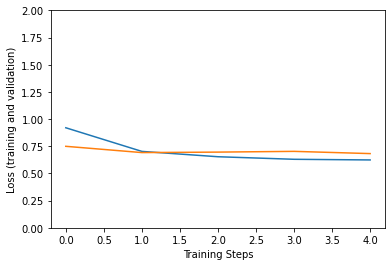

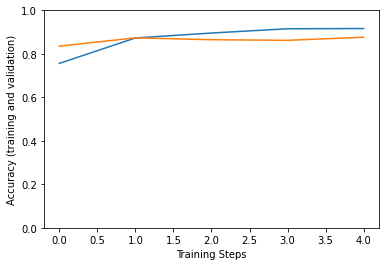

In [10]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

検証データの画像でモデルが機能するか試してみましょう。

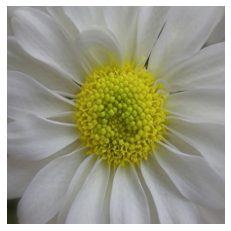

True label: daisy
Predicted label: daisy


In [11]:
def get_class_string_from_index(index):
   for class_string, class_index in valid_generator.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(valid_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

最後に次のようにして、トレーニングされたモデルを、TF Serving または TF Lite（モバイル）用に保存することができます。

In [12]:
saved_model_path = "/tmp/saved_flowers_model"
tf.saved_model.save(model, saved_model_path)

2021-08-14 06:11:22.854366: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/saved_flowers_model/assets


INFO:tensorflow:Assets written to: /tmp/saved_flowers_model/assets


## オプション: TensorFlow Lite にデプロイする

[TensorFlow Lite](https://www.tensorflow.org/lite) では、TensorFlow モデルをモバイルおよび IoT デバイスにデプロイすることができます。以下のコードには、トレーニングされたモデルを TF Lite に変換して、[TensorFlow Model Optimization Toolkit](https://www.tensorflow.org/model_optimization) のポストトレーニングツールを適用する方法が示されています。最後に、結果の質を調べるために、変換したモデルを TF Lite Interpreter で実行しています。

- 最適化せずに変換すると、前と同じ結果が得られます（丸め誤差まで）。
- データなしで最適化して変換すると、モデルの重みを 8 ビットに量子化しますが、それでもニューラルネットワークアクティベーションの推論では浮動小数点数計算が使用されます。これにより、モデルのサイズが約 4 倍に縮小されるため、モバイルデバイスの CPU レイテンシが改善されます。
- 最上部の、ニューラルネットワークアクティベーションの計算は、量子化の範囲を調整するために小規模な参照データセットが提供される場合、8 ビット整数に量子化されます。モバイルデバイスでは、これにより推論がさらに高速化されるため、EdgeTPU などのアクセラレータで実行することが可能となります。

In [ ]:
#@title Optimization settings
# docs_infra: no_execute
# TODO(b/156102192)
optimize_lite_model = False  #@param {type:"boolean"}
#@markdown Setting a value greater than zero enables quantization of neural network activations. A few dozen is already a useful amount.
num_calibration_examples = 60  #@param {type:"slider", min:0, max:1000, step:1}
representative_dataset = None
if optimize_lite_model and num_calibration_examples:
  # Use a bounded number of training examples without labels for calibration.
  # TFLiteConverter expects a list of input tensors, each with batch size 1.
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in train_generator for image in batch),
      num_calibration_examples)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:  # This is optional, see above.
    converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

with open("/tmp/lite_flowers_model", "wb") as f:
  f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if optimize_lite_model else "", len(lite_model_content)))

In [ ]:
# docs_infra: no_execute
interpreter = tf.lite.Interpreter(model_content=lite_model_content)
# This little helper wraps the TF Lite interpreter as a numpy-to-numpy function.
def lite_model(images):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

In [ ]:
#@markdown For rapid experimentation, start with a moderate number of examples.
# docs_infra: no_execute
num_eval_examples = 50  #@param {type:"slider", min:0, max:700}
eval_dataset = ((image, label)  # TFLite expects batch size 1.
                for batch in train_generator
                for (image, label) in zip(*batch))
count = 0
count_lite_tf_agree = 0
count_lite_correct = 0
for image, label in eval_dataset:
  probs_lite = lite_model(image[None, ...])[0]
  probs_tf = model(image[None, ...]).numpy()[0]
  y_lite = np.argmax(probs_lite)
  y_tf = np.argmax(probs_tf)
  y_true = np.argmax(label)
  count +=1
  if y_lite == y_tf: count_lite_tf_agree += 1
  if y_lite == y_true: count_lite_correct += 1
  if count >= num_eval_examples: break
print("TF Lite model agrees with original model on %d of %d examples (%g%%)." %
      (count_lite_tf_agree, count, 100.0 * count_lite_tf_agree / count))
print("TF Lite model is accurate on %d of %d examples (%g%%)." %
      (count_lite_correct, count, 100.0 * count_lite_correct / count))